In [1]:
import numpy as np
import os
import csv
import runtests
import makegraphs
import makegraphs_new
import pandas
from matplotlib import pyplot as plt
import pickle
import scipy.stats as scistats

In [2]:
# plt.rcParams["figure.figsize"] = (15,8)

In [3]:
results_dict_10_31 = pickle.load (open( "10-31-tests-results-dict.p", "rb"))
str(results_dict_10_31)[:100]

"{'onedisk_128k': {'zfs': {'read': {'1': {'1': {'64m': array([[1.50100000e+00, 2.01309429e+03],\n     "

In [4]:
plt.close()
figs, _, _, write_results_dict = makegraphs_new.gen_plots("config.csv", 0, stop=0, save=False, gen_plt=False, test_dir="tests-10-31",start=0, rw_choose=['write'])

In [5]:
figs_all, write_avgs, write_mats = makegraphs_new.gen_plots_from_dict(write_results_dict, "config.csv", 0, stop=0, save=False, gen_plt=False, test_dir="tests", start=10, rw_choose=['write']) 

In [6]:
makegraphs_new.print_info_arr(write_avgs)

------------------
onedisk 128k | zfs write
NJ:1 | IOD:1 | BS:64m :: 144.5997154880702
NJ:4 | IOD:1 | BS:64m :: 149.65989566813556
NJ:8 | IOD:1 | BS:64m :: 155.46144029896553
------------------
onedisk 128k | lustre write
NJ:1 | IOD:1 | BS:64m :: 135.8108341513793
NJ:4 | IOD:1 | BS:64m :: 175.11429489894743
NJ:8 | IOD:1 | BS:64m :: 164.47610002508478
------------------
z2 one 8 1m | zfs write
NJ:1 | IOD:1 | BS:64m :: 899.713509342143
NJ:1 | IOD:2 | BS:64m :: 901.3431899085715
NJ:4 | IOD:1 | BS:64m :: 813.6275124056141
NJ:4 | IOD:2 | BS:64m :: 783.2435905960714
NJ:8 | IOD:1 | BS:64m :: 791.3155407114288
NJ:8 | IOD:2 | BS:64m :: 838.6537597100001
------------------
z2 one 8 1m | lustre write
NJ:1 | IOD:1 | BS:64m :: 498.9747509732143
NJ:1 | IOD:2 | BS:64m :: 499.01184449071434
NJ:4 | IOD:1 | BS:64m :: 554.4621904466667
NJ:4 | IOD:2 | BS:64m :: 532.875067960345
NJ:8 | IOD:1 | BS:64m :: 526.5820512482759
NJ:8 | IOD:2 | BS:64m :: 529.501070523226
------------------
z2 two 8 1m | zfs write
N

In [7]:
list(write_mats.keys())

['onedisk_128k',
 'z2_one_8_1m',
 'z2_two_8_1m',
 'z2_three_8_1m',
 'z3_one_15_1m',
 'z3_two_15_1m',
 'twodisk_1m',
 'fourdisk_1m',
 'eightdisk_1m',
 'sixteendisk_1m',
 'onedisk_1m']

In [56]:
def comp_test_mat(test_mats, testname, stat):
    stat_dict = {'nj':0, 'io':1, 'bs':2}
    axis = stat_dict[stat]
    entry = test_mats[testname]
    # these are out statlists
    mat = entry[0]
    # nj, io, bs = entry[stat_axis+1]
    # numjobs = entry[1]
    # iodepths = entry[2]
    # blocksizes = entry[3]
    title = "Computing over " + stat + ": " + str(entry[axis+1])
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel(stat)
    ax.set_ylabel("MB/s")

    def gen_label_helper (stat_keys, avgs, stds, lin_arr, i, j):
        avg = avgs[i,j]
        std = stds[i,j]
        slope = lin_arr[i,j,0]
        r_val = lin_arr[i,j,2]
        p_val = lin_arr[i,j,3]
        return "%s:%s | %s:%s"%(stat_keys[0],x,stat_keys[1],y) + " || " + "avg: %1.1f | std:%1.1f | slope:%1.1f | rval:%1.1f | pval:%1.1f"%(avg, std, slope, r_val, p_val)

    stat_dict.pop(stat)
    stat_keys = list(stat_dict.keys())
    stat_axis1 = stat_dict[stat_keys[0]]
    stat_axis2 = stat_dict[stat_keys[1]]
    stat_list1 = entry[stat_axis1 + 1]
    stat_list2 = entry[stat_axis2 + 1]

    avgs = np.mean(mat, axis=axis)
    print (avgs.shape)
    stds = np.std(mat, axis=axis)


    # I know this is disgusting but its just so I can iterate through 2 lists of my choosing by excluding one of (nj, io, bs)
    info_arr = []
    info_arr.append(title)
    
    lin_arr = np.zeros(shape=(len(stat_list1), len(stat_list1), 5))
    x = entry[axis+1]
    rearranged_mat = np.moveaxis(mat, [stat_axis1, stat_axis2], [0,1])
    # print ("mat, rearranged:", mat.shape, rearranged_mat.shape)
    # print ("stat1: ", len(stat_list1))
    # print ("stat2: ", len(stat_list2))
    if axis==2:
        x = [small_x[:-1] for small_x in x]
    x = [int(small_x) for small_x in x]

    for i, a in enumerate(stat_list1):
        for j, b in enumerate(stat_list2):
            # iterate through axis that is not our test stat 
            y = rearranged_mat[i,j,:]
            # vals = slope, intercept, r_value, p_value, std_err
            vals = scistats.linregress (x,y)
            lin_arr[i,j] = vals
            label = gen_label_helper(stat_keys, avgs, stds, lin_arr, i, j)
            ax.plot (x, y, label=label)
            info_arr.append (label)
    ax.legend()
    return info_arr, lin_arr


In [57]:
    if axis==2:
        x = [small_x[:-1] for small_x in x]
    x = [int(small_x) for small_x in x]
    for i in range(len(stat_list1)):
        for j in range(len(stat_list2)):
            # iterate through axis that is not our test stat 
            y = rearranged_mat[i,j,:]
            # print ("x, y:", x, y)
            # vals = slope, intercept, r_value, p_value, std_err
            vals = scistats.linregress (x,y)
            lin_arr[i,j] = vals

            ax.plot (x, y, label=gen_lebel_helper(avgs, stds, lin_arr, i, j))
    ax.legend()

    info_arr = []
    # I know this is disgusting but its just so I can iterate through 2 lists of my choosing by excluding one of (nj, io, bs)
    info_arr.append(title)
    for i, x in enumerate(stat_list1):
        for j, y in enumerate(stat_list2):
            info_arr.append (gen_lebel_helper(avgs, stds, lin_arr, i, j))
    return info_arr, lin_arr

NameError: name 'axis' is not defined

(2, 1)
Computing over nj: ['1', '4', '8']
io:[1, 4, 8] | bs:[499.7055335  552.33413125 529.59562976] || avg: 527.2 | std:21.6 | slope:3.7 | rval:0.5 | pval:0.7
io:[1, 4, 8] | bs:[498.37091358 539.4001149  492.00305671] || avg: 509.9 | std:21.0 | slope:-1.5 | rval:-0.2 | pval:0.9


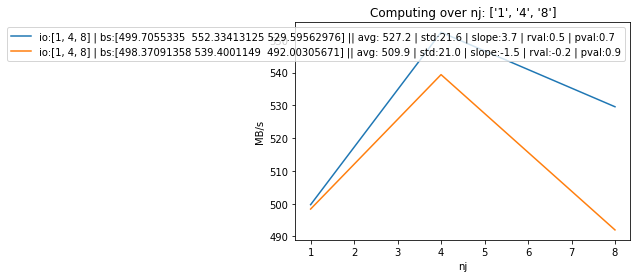

In [58]:
# nj, io, bs
testname = 'z2_one_8_1m'
info_arr, lin_arr = comp_test_mat(write_mats, testname, 'nj')
for line in info_arr:
    print (line)

In [43]:
mat = write_mats['z2_one_8_1m'][0]
print (mat.shape)
rearranged_mat = np.moveaxis(mat, [1, 2], [0,1])
print (rearranged_mat.shape)
print (np.shares_memory(mat, rearranged_mat))

(3, 2, 1)
(2, 1, 3)
True


In [11]:
# onedisk_zfs_write = results_dict_10_31['onedisk_128k']['zfs']['write']
# np.mean(onedisk_zfs_write['1']['1']['64m'],axis=0).shape

In [12]:
figs, _, _, read_results_dict = makegraphs_new.gen_plots("config.csv", 0, stop=0, save=False, gen_plt=False, test_dir="tests-10-31",start=0, rw_choose=['read'])

In [13]:
figs_all, read_avgs = makegraphs_new.gen_plots_from_dict(read_results_dict, "config.csv", 0, stop=0, save=False, gen_plt=True, test_dir="tests", start=10, rw_choose=['read'], avg_io=False) 

TypeError: gen_plots_from_dict() got an unexpected keyword argument 'avg_io'

In [ ]:
makegraphs_new.print_info_arr(read_avgs)

In [ ]:
# pickle.dump (results_dict, open( "10-31-tests-results-dict.p", "wb"))

In [ ]:
results_dict_10_31['onedisk_128k']['zfs']['write']['1']['1']

In [ ]:
figs_all, avgs = makegraphs_new.gen_plots_from_dict(results_dict_10_31, "config.csv", 0, stop=0, save=False, gen_plt=True, test_dir="tests", start=0, rw_choose=None, fs_choose=None, avg_io=False,graph_save_dir_prefix="")